In [1]:
#Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()

#Check version
print('tensorflow version:',tf.__version__)

tensorflow version: 2.8.0


In [2]:
#Load Fashion MNIST dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train = len(train_images)
size_of_test = len(test_images)
num_of_class = 10

print("The number of train images:",size_of_train)
print("The number of test images:",size_of_test)


4431872/4422102 [==============================] - 0s 0us/step
The number of train images: 60000
The number of test images: 10000


In [3]:

print('==Before normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)

##Dataset Pre-processing##
#Normalization
train_images= train_images/255.
test_images =test_images/255.

#Reshape(Adding chaneel)
train_images = train_images.reshape((size_of_train,28,28,1))
test_images = test_images.reshape((size_of_test,28,28,1))

#Convet label
train_labels = tf.keras.utils.to_categorical(train_labels,num_of_class)
test_labels = tf.keras.utils.to_categorical(test_labels,num_of_class)

print('==Afte normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)


==Before normalization==
Image Shape: (60000, 28, 28)
Value MIN: 0, MEAN:97.25, MAX:255
[9 0 0 ... 3 0 5]
==Afte normalization==
Image Shape: (60000, 28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
#Define blocks
def channel_attention(x, filter):
    ####Fill your code####
    
    GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
    fc1 = tf.keras.layers.Dense(filter) (GAP)
    sigma1 = tf.keras.layers.ReLU()(fc1)
    fc2 = tf.keras.layers.Dense(filter) (sigma1)
    sigma2 = tf.sigmoid(fc2)
    #r = 4
    #print(x,'\n',sigma1)
    x = tf.keras.layers.Multiply()([x,sigma2])

    return  x

def spatial_attention(x, filter):
    ####Fill your code####
    conv = tf.keras.layers.Conv2D(filters=filter, 
                               kernel_size=3, strides= (1,1),
                               padding='same')(x)
    sigma1 = tf.sigmoid(conv)
    #print(x,'\n',conv,'\n',sigma1)
    x = tf.keras.layers.Multiply()([x,sigma1])

    return  x

def attention_module(x, filter, attention_type):

    if attention_type is 'channel':
        # Channel Attnetion only
        x = channel_attention(x,filter)
        output = x
    elif attention_type is 'spatial':
        # Spatial Attention only
        x = spatial_attention(x,filter)
        output = x
    elif attention_type is 'parellel_add':
        # Parelle Attention (Add)
        x1 = channel_attention(x,filter)
        x2 = spatial_attention(x,filter) 
        x = tf.keras.layers.Add() ([x1,x2])
        output = x

    elif attention_type is 'parellel_mul':
        # Parelle Attention (Mul)
        x1 = channel_attention(x,filter) 
        x2 = spatial_attention(x,filter) 
        x = tf.keras.layers.Multiply()([x1,x2])
        output = x


    elif attention_type is 'serial_ca':
        # Serial Attention, CA first
        x = channel_attention(x,filter)
        x = spatial_attention(x,filter) 
        output = x

    elif attention_type is 'serial_sa':
        # Serial Attention, SA first
        x = spatial_attention(x,filter)
        x = channel_attention(x,filter) 
        output = x

    else:
        output  = x
    
    return output


def res_block(x,filter,stride,name):
    input = x
    if stride != 1:
        input = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,name=name+'_pooling_conv')(input)
        input = tf.keras.layers.BatchNormalization(name=name+'_pooling_bn')(input)

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,padding='same',name=name+'_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn1')(x)
    x = tf.nn.relu(x,name=name+'_relu1')

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=1,padding='same',name=name+'_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn2')(x)
    x = tf.keras.layers.add([input,x],name=name+'_add')

    x = tf.nn.relu(x,name=name+'_relu2')
    return x




def model_builder(x,attention):
    #######################
    #Add Attention Module #
    
    x = tf.keras.layers.Conv2D(filters=64,kernel_size=7,strides=2,activation='relu',padding='same',name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same',name='conv1_max_pool')(x)

    x = res_block(x,64,2,'ResBlock21') 
    x = attention_module(x,64,attention)

    x = res_block(x,64,1,'ResBlock22')
    x = attention_module(x,64,attention)

    x = res_block(x,128,2,'ResBlock31')
    x = attention_module(x,128,attention)

    x = res_block(x,128,1,'ResBlock32')

    x =tf.keras.layers.GlobalAveragePooling2D(name='GAP')(x) 
    pred = tf.keras.layers.Dense(num_of_class,activation='softmax')(x)
    
    return pred


inputs = tf.keras.Input(shape=(28,28,1))

pred_normal = model_builder(inputs,None)

pred_channel = model_builder(inputs,attention='channel')
pred_spatial = model_builder(inputs,attention='spatial')

pred_parellel_add = model_builder(inputs,attention='parellel_add')
pred_parellel_mul = model_builder(inputs,attention='parellel_mul')

pred_serial_ca = model_builder(inputs,attention='serial_ca')
pred_serial_sa = model_builder(inputs,attention='serial_sa')


model_normal = tf.keras.Model(inputs=inputs,outputs=pred_normal)
model_channel = tf.keras.Model(inputs=inputs,outputs=pred_channel)
model_spatial = tf.keras.Model(inputs=inputs,outputs=pred_spatial)
model_parellel_add = tf.keras.Model(inputs=inputs,outputs=pred_parellel_add)
model_parellel_mul = tf.keras.Model(inputs=inputs,outputs=pred_parellel_mul)
model_serial_ca = tf.keras.Model(inputs=inputs,outputs=pred_serial_ca)
model_serial_sa = tf.keras.Model(inputs=inputs,outputs=pred_serial_sa)

model_normal.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 14, 14, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 conv1_max_pool (MaxPooling2D)  (None, 7, 7, 64)     0           ['conv1_bn[0][0]']               
                                                                                            

In [5]:
#Select optimizer and compile Model
optimizer = tf.keras.optimizers.Adam()
model_normal.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_channel.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_spatial.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_add.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_mul.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_ca.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_sa.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [6]:
#Train Normal Model
print('Training Normal Model')
hist_normal = model_normal.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))


Training Normal Model
Epoch 1/30
3750/3750 [==============================] - 60s 12ms/step - loss: 0.5445 - accuracy: 0.8020 - val_loss: 0.5122 - val_accuracy: 0.8142
Epoch 2/30
3750/3750 [==============================] - 39s 10ms/step - loss: 0.4285 - accuracy: 0.8408 - val_loss: 0.4597 - val_accuracy: 0.8295
Epoch 3/30
3750/3750 [==============================] - 39s 11ms/step - loss: 0.3937 - accuracy: 0.8529 - val_loss: 0.4176 - val_accuracy: 0.8453
Epoch 4/30
3750/3750 [==============================] - 39s 10ms/step - loss: 0.3695 - accuracy: 0.8633 - val_loss: 0.4068 - val_accuracy: 0.8483
Epoch 5/30
3750/3750 [==============================] - 39s 10ms/step - loss: 0.3514 - accuracy: 0.8688 - val_loss: 0.3889 - val_accuracy: 0.8572
Epoch 6/30
3750/3750 [==============================] - 39s 10ms/step - loss: 0.3364 - accuracy: 0.8748 - val_loss: 0.4383 - val_accuracy: 0.8329
Epoch 7/30
3750/3750 [==============================] - 39s 10ms/step - loss: 0.3232 - accuracy: 0.880

In [7]:
#Train Channel Attention Model
print('Training Channel Attention Model')
hist_channel = model_channel.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Channel Attention Model
Epoch 1/30
3750/3750 [==============================] - 46s 12ms/step - loss: 0.5165 - accuracy: 0.8102 - val_loss: 0.4935 - val_accuracy: 0.8208
Epoch 2/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.3880 - accuracy: 0.8565 - val_loss: 0.4063 - val_accuracy: 0.8500
Epoch 3/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.3493 - accuracy: 0.8701 - val_loss: 0.3935 - val_accuracy: 0.8560
Epoch 4/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.3256 - accuracy: 0.8785 - val_loss: 0.3524 - val_accuracy: 0.8689
Epoch 5/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.3067 - accuracy: 0.8864 - val_loss: 0.3121 - val_accuracy: 0.8862
Epoch 6/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.2904 - accuracy: 0.8922 - val_loss: 0.3073 - val_accuracy: 0.8870
Epoch 7/30
3750/3750 [==============================] - 44s 12ms/step - loss: 0.2773 - accu

In [8]:
#Train Spatial Attention Model
print('Training Spatial Attention Model')
hist_spatial = model_spatial.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Spatial Attention Model
Epoch 1/30
3750/3750 [==============================] - 52s 13ms/step - loss: 0.4630 - accuracy: 0.8280 - val_loss: 0.3850 - val_accuracy: 0.8555
Epoch 2/30
3750/3750 [==============================] - 50s 13ms/step - loss: 0.3475 - accuracy: 0.8694 - val_loss: 0.3714 - val_accuracy: 0.8626
Epoch 3/30
3750/3750 [==============================] - 50s 13ms/step - loss: 0.3140 - accuracy: 0.8819 - val_loss: 0.3439 - val_accuracy: 0.8708
Epoch 4/30
3750/3750 [==============================] - 50s 13ms/step - loss: 0.2911 - accuracy: 0.8907 - val_loss: 0.3525 - val_accuracy: 0.8750
Epoch 5/30
3750/3750 [==============================] - 50s 13ms/step - loss: 0.2732 - accuracy: 0.8984 - val_loss: 0.3284 - val_accuracy: 0.8792
Epoch 6/30
3750/3750 [==============================] - 62s 17ms/step - loss: 0.2577 - accuracy: 0.9036 - val_loss: 0.2920 - val_accuracy: 0.8913
Epoch 7/30
3750/3750 [==============================] - 51s 14ms/step - loss: 0.2458 - accu

In [11]:
#Train Parelle add  Model
print('Training Parelle add  Model')
hist_parellel_add = model_parellel_add.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Parelle add  Model
Epoch 1/30
3750/3750 [==============================] - 57s 15ms/step - loss: 0.4013 - accuracy: 0.8510 - val_loss: 0.3750 - val_accuracy: 0.8617
Epoch 2/30
3750/3750 [==============================] - 56s 15ms/step - loss: 0.3364 - accuracy: 0.8755 - val_loss: 0.3752 - val_accuracy: 0.8603
Epoch 3/30
3750/3750 [==============================] - 56s 15ms/step - loss: 0.3038 - accuracy: 0.8868 - val_loss: 0.3407 - val_accuracy: 0.8740
Epoch 4/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.2848 - accuracy: 0.8936 - val_loss: 0.3186 - val_accuracy: 0.8843
Epoch 5/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.2663 - accuracy: 0.9006 - val_loss: 0.3158 - val_accuracy: 0.8827
Epoch 6/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.2556 - accuracy: 0.9039 - val_loss: 0.2945 - val_accuracy: 0.8937
Epoch 7/30
3750/3750 [==============================] - 56s 15ms/step - loss: 0.2444 - accuracy:

In [15]:
#Train Parellel Mul Model
print('Training  Parellel Mul Model')
hist_parellel_mul = model_parellel_mul.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training  Parellel Mul Model
Epoch 1/30
3750/3750 [==============================] - 60s 16ms/step - loss: 0.5221 - accuracy: 0.8051 - val_loss: 0.4801 - val_accuracy: 0.8192
Epoch 2/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.3964 - accuracy: 0.8508 - val_loss: 0.3811 - val_accuracy: 0.8557
Epoch 3/30
3750/3750 [==============================] - 60s 16ms/step - loss: 0.3526 - accuracy: 0.8679 - val_loss: 0.3699 - val_accuracy: 0.8624
Epoch 4/30
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3245 - accuracy: 0.8791 - val_loss: 0.3674 - val_accuracy: 0.8656
Epoch 5/30
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3039 - accuracy: 0.8873 - val_loss: 0.3388 - val_accuracy: 0.8776
Epoch 6/30
3750/3750 [==============================] - 58s 16ms/step - loss: 0.2898 - accuracy: 0.8923 - val_loss: 0.3792 - val_accuracy: 0.8576
Epoch 7/30
3750/3750 [==============================] - 60s 16ms/step - loss: 0.2771 - accuracy

In [16]:
#Train Serial CA Model
print('Training Serial CA Model')
hist_serial_ca = model_serial_ca.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Serial CA Model
Epoch 1/30
3750/3750 [==============================] - 62s 16ms/step - loss: 0.4673 - accuracy: 0.8281 - val_loss: 0.3942 - val_accuracy: 0.8540
Epoch 2/30
3750/3750 [==============================] - 56s 15ms/step - loss: 0.3416 - accuracy: 0.8732 - val_loss: 0.3487 - val_accuracy: 0.8667
Epoch 3/30
3750/3750 [==============================] - 58s 16ms/step - loss: 0.3043 - accuracy: 0.8863 - val_loss: 0.3218 - val_accuracy: 0.8811
Epoch 4/30
3750/3750 [==============================] - 57s 15ms/step - loss: 0.2805 - accuracy: 0.8948 - val_loss: 0.2931 - val_accuracy: 0.8907
Epoch 5/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.2612 - accuracy: 0.9020 - val_loss: 0.2972 - val_accuracy: 0.8927
Epoch 6/30
3750/3750 [==============================] - 57s 15ms/step - loss: 0.2490 - accuracy: 0.9066 - val_loss: 0.3060 - val_accuracy: 0.8890
Epoch 7/30
3750/3750 [==============================] - 57s 15ms/step - loss: 0.2360 - accuracy: 0.

In [17]:
#Train Serial SA Model
print('Training Serial SA Model')
hist_serial_sa = model_serial_sa.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Serial SA Model
Epoch 1/30
3750/3750 [==============================] - 60s 16ms/step - loss: 0.4653 - accuracy: 0.8280 - val_loss: 0.3903 - val_accuracy: 0.8560
Epoch 2/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.3470 - accuracy: 0.8714 - val_loss: 0.3582 - val_accuracy: 0.8654
Epoch 3/30
3750/3750 [==============================] - 59s 16ms/step - loss: 0.3112 - accuracy: 0.8853 - val_loss: 0.3458 - val_accuracy: 0.8687
Epoch 4/30
3750/3750 [==============================] - 58s 16ms/step - loss: 0.2893 - accuracy: 0.8925 - val_loss: 0.3103 - val_accuracy: 0.8879
Epoch 5/30
3750/3750 [==============================] - 61s 16ms/step - loss: 0.2725 - accuracy: 0.8988 - val_loss: 0.2981 - val_accuracy: 0.8928
Epoch 6/30
3750/3750 [==============================] - 61s 16ms/step - loss: 0.2581 - accuracy: 0.9039 - val_loss: 0.3084 - val_accuracy: 0.8910
Epoch 7/30
3750/3750 [==============================] - 58s 16ms/step - loss: 0.2471 - accuracy: 0.

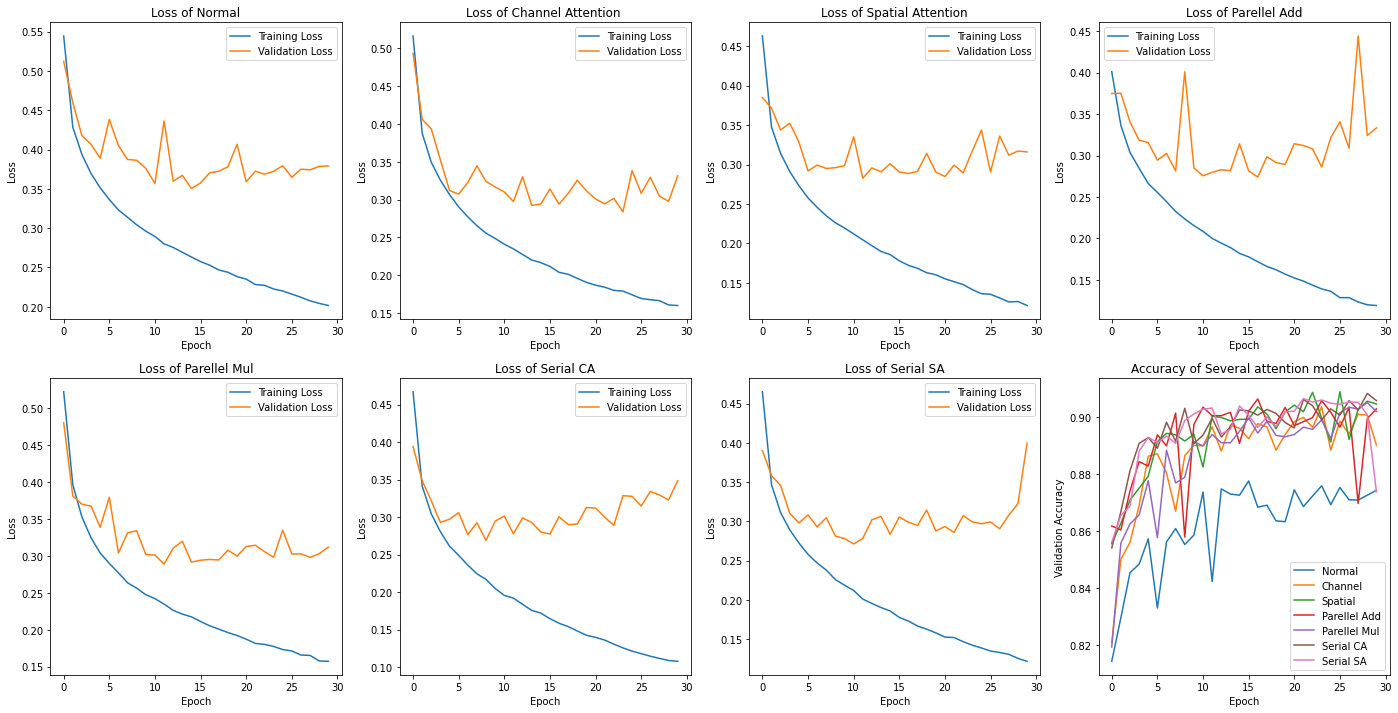

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(hist_normal.history['loss'])
plt.plot(hist_normal.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(hist_channel.history['loss'])
plt.plot(hist_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(hist_spatial.history['loss'])
plt.plot(hist_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(hist_parellel_add.history['loss'])
plt.plot(hist_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(hist_parellel_mul.history['loss'])
plt.plot(hist_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(hist_serial_ca.history['loss'])
plt.plot(hist_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(hist_serial_sa.history['loss'])
plt.plot(hist_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(hist_normal.history['val_accuracy'])
plt.plot(hist_channel.history['val_accuracy'])
plt.plot(hist_spatial.history['val_accuracy'])
plt.plot(hist_parellel_add.history['val_accuracy'])
plt.plot(hist_parellel_mul.history['val_accuracy'])
plt.plot(hist_serial_ca.history['val_accuracy'])
plt.plot(hist_serial_sa.history['val_accuracy'])

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()